In [26]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import bayes3d as b
from tqdm import tqdm
import pytorch3d.transforms as t3d
import nvdiffrast.torch as dr


ModuleNotFoundError: No module named 'pytorch3d'

In [27]:
!pip install pytorch3d

ERROR: Could not find a version that satisfies the requirement pytorch3d (from versions: none)
ERROR: No matching distribution found for pytorch3d


In [6]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 0.01
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = 256
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [52]:
def projection(x=0.1, n=1.0, f=50.0):
    return np.array([[n/x,    0,            0,              0],
                     [  0,  n/x,            0,              0],
                     [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                     [  0,    0,           -1,              0]]).astype(np.float32)
def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]]).astype(np.float32)
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()
mvp = torch.tensor(np.matmul(projection(x=0.4), translate(0, 0, 0.0)).astype(np.float32), device='cuda')

In [60]:
def quaternion_to_matrix(poses: torch.Tensor) -> torch.Tensor:
    """
    Convert rotations given as quaternions to rotation matrices.

    Args:
        quaternions: quaternions with real part first,
            as tensor of shape (..., 4).

    Returns:
        Rotation matrices as tensor of shape (..., 3, 3).
    """
    positions = poses[...,:3]
    quaternions = poses[...,3:]
    r, i, j, k = torch.unbind(quaternions, -1)
    x, y, z = torch.unbind(positions, -1)
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = torch.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            x,
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            y,
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
            z,
            0.0 * x,
            0.0 * x,
            0.0 * x,
            0.0 * x + 1.0,
        ),
        -1,
    )
    rotation_matrices = o.reshape(quaternions.shape[:-1] + (4, 4))
    return rotation_matrices

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, resolution: int):
    # Setup TF graph for reference.
    depth_ = pos[..., 2:3]
    depth = torch.tensor([[[(z_val/1)] for z_val in depth_.squeeze()]], dtype=torch.float32).cuda()
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(depth, rast_out, pos_idx)
    # color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color
    # return rast_out[:,:,:,2:3]


In [54]:
datadir = "/home/nishadgothoskar/bayes3d/nvdiffrast/samples/data"
with np.load(f'{datadir}/cube_p.npz') as f:
    pos_idx, pos, col_idx, col = f.values()
print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))

# Some input geometry contains vertex positions in (N, 4) (with v[:,3]==1).  Drop
# the last column in that case.
if pos.shape[1] == 4: pos = pos[:, 0:3]

# Create position/triangle index tensors
pos_idx = torch.from_numpy(pos_idx.astype(np.int32)).cuda()
vtx_pos = torch.from_numpy(pos.astype(np.float32)).cuda()
print(pos_idx.shape, vtx_pos.shape)

# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# idx = 14
# mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
# m = b.utils.load_mesh(mesh_path)
# m = b.utils.scale_mesh(m, 1.0/100.0)

# vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
# pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
# col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
# vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()

Mesh has 12 triangles and 24 vertices.
torch.Size([12, 3]) torch.Size([24, 3])


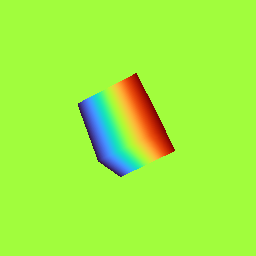

In [61]:
pose_target = torch.tensor([0.0, 0.0, -5.0, 1.0, 1.2, 0.4, 1.0]).cuda()
rast_target = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_target)), vtx_pos, pos_idx,  resolution)
img_target  = rast_target[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


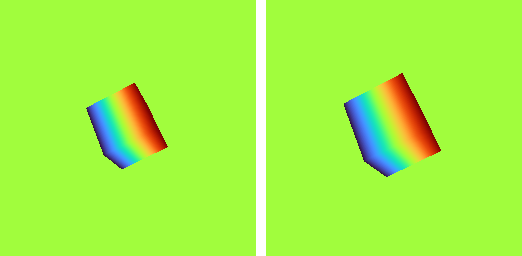

In [99]:
pose_opt = torch.tensor([0.0, 0.0, -6.0, 1.0, 1.2, 0.4, 1.0],dtype=torch.float32, device='cuda', requires_grad=True)
loss_best   = np.inf

rast_opt = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_opt)), vtx_pos, pos_idx,  resolution)
img_opt  = rast_opt[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_opt[:,:,0]* 255.0) ,
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


In [100]:
diff = (rast_opt - rast_target)**2 # L2 norm.
diff.sum()

tensor(281.8252, device='cuda:0', grad_fn=<SumBackward0>)

In [101]:
optimizer = torch.optim.Adam([pose_opt],  lr=0.00001)
images = []

for _ in tqdm(range(200)):    
    rast_opt = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_opt)), vtx_pos, pos_idx,  resolution)

    diff = (rast_opt - rast_target)**2 # L2 norm.
    loss = torch.mean(diff)
    loss_val = float(loss)
    
    if (loss_val < loss_best) and (loss_val > 0.0):
        loss_best = loss_val
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss)    
    with torch.no_grad():
        pose_opt /= torch.sum(pose_opt**2)**0.5
    
    img_opt  = rast_opt[0].detach().cpu().numpy()
    images.append(
        b.hstack_images([
            b.get_depth_image(img_opt[:,:,0]* 255.0) ,
            b.get_depth_image(img_target[:,:,0]* 255.0) ,
        ])
    )

  6%|▌         | 11/200 [00:00<00:01, 103.84it/s]

tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0',

 17%|█▋        | 34/200 [00:00<00:01, 107.36it/s]

tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0',

 29%|██▉       | 58/200 [00:00<00:01, 110.64it/s]

tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0969, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0',

 41%|████      | 82/200 [00:00<00:01, 111.76it/s]

tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0',

 53%|█████▎    | 106/200 [00:00<00:00, 112.15it/s]

tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0',

 65%|██████▌   | 130/200 [00:01<00:00, 111.63it/s]

tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0',

 77%|███████▋  | 154/200 [00:01<00:00, 111.73it/s]

tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0966, device='cuda:0',

 89%|████████▉ | 178/200 [00:01<00:00, 109.96it/s]

tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0',

100%|██████████| 200/200 [00:01<00:00, 109.38it/s]

tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0964, device='cuda:0',

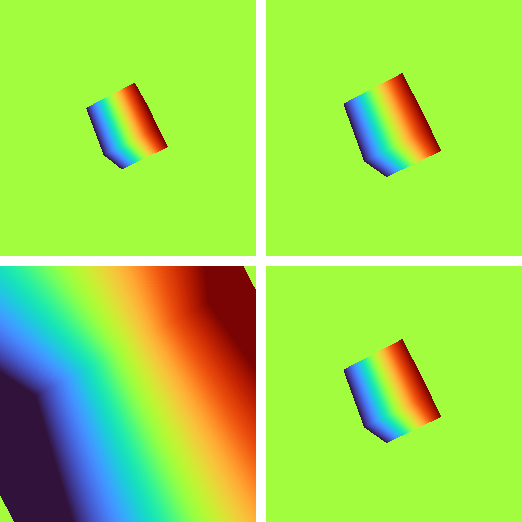

In [102]:
b.vstack_images([images[0],images[-1]])

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

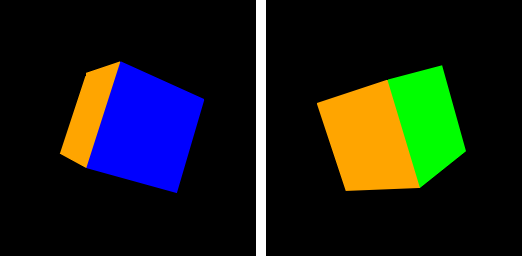